# Product Market Forecasting using Bass Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy.integrate import odeint
from scipy.misc import derivative
import statsmodels.formula.api as smf
from datetime import datetime

In [2]:
def densityFunction(p, q, t):
    return (np.exp((p+q)*t)*p*(p+q)**2)/((p*np.exp((p+q)*t)+q)**2)

### Successful product case

In [3]:
t = np.linspace(1, 20, 20) #time
m = 100000 #market size
p = 0.01 #coefficient of innovation
q = 0.2 #coefficient of imitation

In [4]:
f = densityFunction(p,q,t)

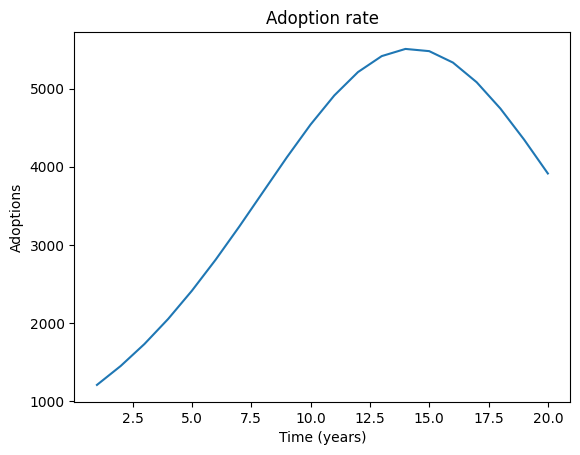

In [5]:
fig = plt.figure()
plt.plot(t, m*f)
plt.ylabel('Adoptions')
plt.xlabel('Time (years)')
plt.title("Adoption rate")
#plt.legend()
plt.show()

In [6]:
peak_time = -1/(p+q)*np.log(p/q)
print(peak_time)

14.26539177882853


### Unsuccessful product case

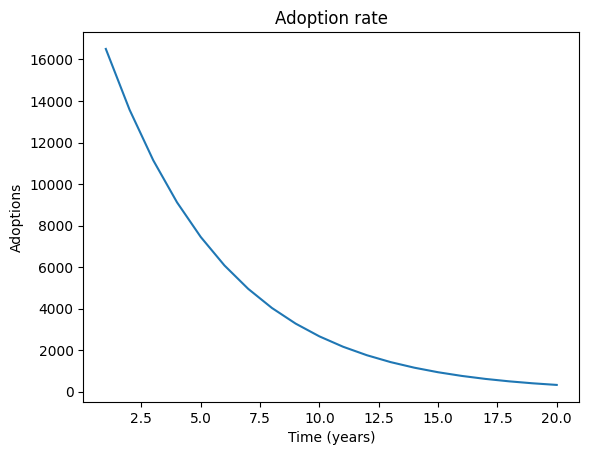

In [7]:
p=0.2
q=0.01
f = densityFunction(p,q,t)
fig = plt.figure()
plt.plot(t, m*f)
plt.ylabel('Adoptions')
plt.xlabel('Time (years)')
plt.title("Adoption rate")
#plt.legend()
plt.show()

In [8]:
peak_time = -1/(p+q)*np.log(p/q)
print(peak_time)

-14.265391778828528


In [9]:
# Bass model
def FF(p, q, t):
    return p*(np.exp((p+q)*t)-1)/(p*np.exp((p+q)*t)+q)

# iPhone Sales Forecast

In [10]:
data = pd.read_csv('iphone_sales.txt', delim_whitespace=True)

In [11]:
data.head()

,Quarter,Sales_MM_units
0,Q3_07,0.27
1,Q4_07,1.12
2,Q1_08,2.32
3,Q2_08,1.70
4,Q3_08,0.72


In [12]:
quarter = data['Quarter']

In [13]:
qs = quarter.str.replace(r'(Q\d)_(\d+)', r'20\2-\1')
qs

/tmp/ipykernel_6516/3643725632.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  qs = quarter.str.replace(r'(Q\d)_(\d+)', r'20\2-\1')


0     2007-Q3
1     2007-Q4
2     2008-Q1
3     2008-Q2
4     2008-Q3
5     2008-Q4
6     2009-Q1
7     2009-Q2
8     2009-Q3
9     2009-Q4
10    2010-Q1
11    2010-Q2
12    2010-Q3
13    2010-Q4
14    2011-Q1
15    2011-Q2
16    2011-Q3
17    2011-Q4
18    2012-Q1
19    2012-Q2
20    2012-Q3
21    2012-Q4
22    2013-Q1
23    2013-Q2
24    2013-Q3
25    2013-Q4
26    2014-Q1
27    2014-Q2
28    2014-Q3
29    2014-Q4
30    2015-Q1
31    2015-Q2
32    2015-Q3
33    2015-Q4
34    2016-Q1
Name: Quarter, dtype: object

In [14]:
data['date'] = pd.PeriodIndex(qs.values, freq='Q').to_timestamp()


In [64]:
date = data['date']
date

0    2010-01-01
1    2010-04-01
2    2010-07-01
3    2010-10-01
4    2011-01-01
5    2011-04-01
6    2011-07-01
7    2011-10-01
8    2012-01-01
9    2012-04-01
10   2012-07-01
11   2012-10-01
12   2013-01-01
13   2013-04-01
14   2013-07-01
15   2013-10-01
16   2014-01-01
17   2014-04-01
18   2014-07-01
19   2015-01-01
20   2015-04-01
21   2015-07-01
Name: date, dtype: datetime64[ns]

In [16]:
sales = data['Sales_MM_units']

In [17]:
cum_sales = np.cumsum(sales)

In [18]:
cum_sales_squared = cum_sales**2

In [19]:
mod = smf.ols(formula='sales ~ cum_sales + cum_sales_squared', data=data)

In [20]:
res = mod.fit()

In [21]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     109.9
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           4.61e-15
Time:                        23:05:49   Log-Likelihood:                -120.18
No. Observations:                  35   AIC:                             246.4
Df Residuals:                      32   BIC:                             251.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.6963      2.20

In [22]:
b = res.params

In [23]:
b

Intercept            3.696307
cum_sales            0.112994
cum_sales_squared   -0.000055
dtype: float64

In [24]:
m1 = (-b['cum_sales']+np.sqrt(b['cum_sales']**2 - 4*b['Intercept']*b['cum_sales_squared']))/(2*b['cum_sales_squared'])
m1

-32.20691009875942

In [25]:
m2 = (-b['cum_sales']-np.sqrt(b['cum_sales']**2 - 4*b['Intercept']*b['cum_sales_squared']))/(2*b['cum_sales_squared'])
m2

2083.822017493281

In [26]:
m = max(m1, m2)

In [27]:
print(m)

2083.822017493281


In [28]:
p = b['Intercept']/m

In [29]:
q = -m*b['cum_sales_squared']

In [30]:
print("p = ",p)
print("q = ", q)

p =  0.00177381124189984
q =  0.114767511363667


In [31]:
date_forecast = pd.date_range(start='2007-Q3', end='2030-Q3', freq='QS')

In [32]:
t = range(len(date_forecast))

In [33]:
f = densityFunction(p,q,t)
sales_forecast = m*f

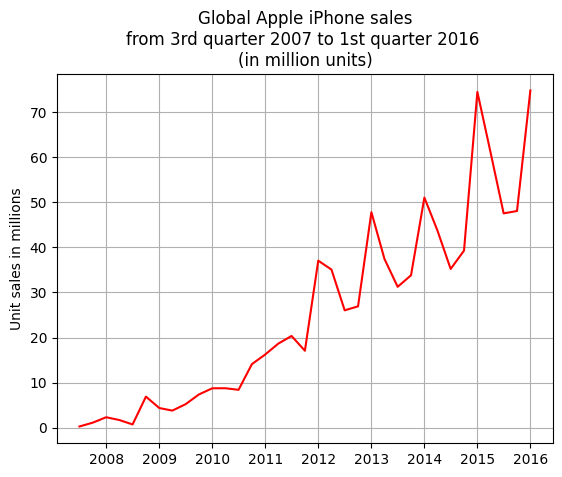

In [34]:
fig, ax = plt.subplots()
ax.plot(date, sales, color='red')
plt.ylabel('Unit sales in millions')
#plt.xlabel('time')
plt.title("Global Apple iPhone sales\nfrom 3rd quarter 2007 to 1st quarter 2016 \n(in million units)")
#plt.legend()
ax.grid(True)
plt.show()

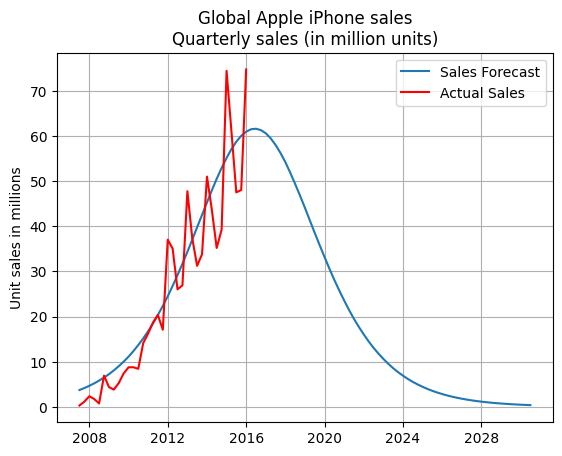

In [35]:
fig, ax = plt.subplots()
ax.plot(date_forecast, sales_forecast, label='Sales Forecast')
ax.plot(date, sales, color='red', label='Actual Sales')
plt.ylabel('Unit sales in millions')
#plt.xlabel('time')
plt.title("Global Apple iPhone sales\nQuarterly sales (in million units)")
plt.legend()
ax.grid(True)
plt.show()

In [36]:
sales_apple = sales
date_apple = date
date_forecast_apple = date_forecast
sales_forecast_apple = sales_forecast

## Sales Peak

In [37]:
peak_time = -1/(p+q)*np.log(p/q)

In [38]:
print(peak_time)

35.77939457746889


In [39]:
print(data['Sales_MM_units'].idxmax() + 1)

35


# Samsumg Galaxy Phone Sales

In [40]:
data = pd.read_csv('galaxy_sales.csv')

In [41]:
data.head()

,Quarter,sales
0,Q1 '10,64.90
1,Q2 '10,65.33
2,Q3 '10,71.67
3,Q4 '10,79.17
4,Q1 '11,68.78


In [42]:
quarter = data['Quarter']

In [43]:
qs = quarter.str.replace(r"(Q\d) '(\d+)", r'20\2-\1')

/tmp/ipykernel_6516/2321454220.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  qs = quarter.str.replace(r"(Q\d) '(\d+)", r'20\2-\1')


In [44]:
qs = qs.str.replace('*', '')

/tmp/ipykernel_6516/106007233.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  qs = qs.str.replace('*', '')


In [45]:
data['date'] = pd.PeriodIndex(qs.values, freq='Q').to_timestamp()

In [46]:
date = data['date']

In [47]:
# Get coefficients
sales = data['sales']

In [48]:
cum_sales = np.cumsum(sales)
cum_sales_squared = cum_sales**2

In [49]:
mod = smf.ols(formula='sales ~ cum_sales + cum_sales_squared', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     43.44
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           8.17e-08
Time:                        23:05:51   Log-Likelihood:                -73.418
No. Observations:                  22   AIC:                             152.8
Df Residuals:                      19   BIC:                             156.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            53.7484      4.50

In [50]:
b = res.params

In [51]:
print(b)

Intercept            53.748387
cum_sales             0.076600
cum_sales_squared    -0.000028
dtype: float64


In [52]:
m1 = (-b['cum_sales']+np.sqrt(b['cum_sales']**2 - 4*b['Intercept']*b['cum_sales_squared']))/(2*b['cum_sales_squared'])
m2 = (-b['cum_sales']-np.sqrt(b['cum_sales']**2 - 4*b['Intercept']*b['cum_sales_squared']))/(2*b['cum_sales_squared'])

In [53]:
m = max(m1, m2)
print(m)

3308.9652182182112


In [54]:
p = b['Intercept']/m
q = -m*b['cum_sales_squared']
print("p = ",p)
print("q = ", q)

p =  0.016243261464994822
q =  0.09284320017915801


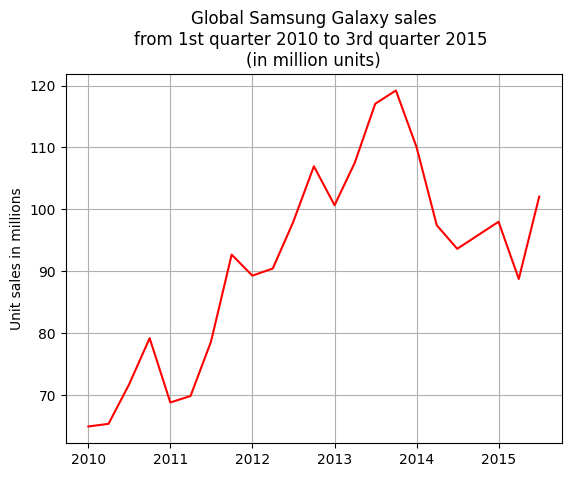

In [55]:
fig, ax = plt.subplots()
ax.plot(date, sales, color='red')
plt.ylabel('Unit sales in millions')
#plt.xlabel('time')
plt.title("Global Samsung Galaxy sales\nfrom 1st quarter 2010 to 3rd quarter 2015 \n(in million units)")
#plt.legend()
ax.grid(True)
plt.show()

In [56]:
date_forecast = pd.date_range(start='2010-Q1', end='2030-Q3', freq='QS')

In [57]:
t = range(len(date_forecast))
f = densityFunction(p,q,t)
sales_forecast = m*f

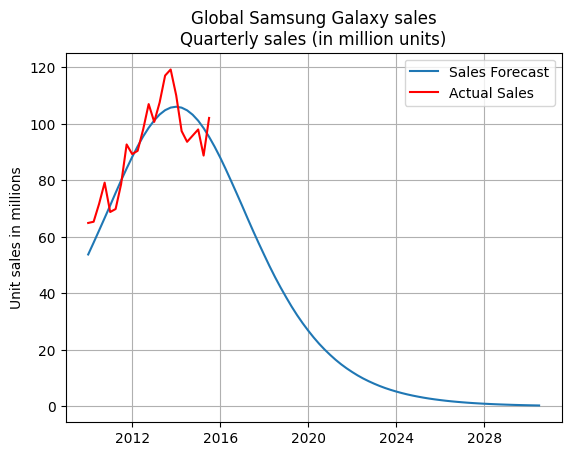

In [58]:
fig, ax = plt.subplots()
ax.plot(date_forecast, sales_forecast, label='Sales Forecast')
ax.plot(date, sales, color='red', label='Actual Sales')
plt.ylabel('Unit sales in millions')
#plt.xlabel('time')
plt.title("Global Samsung Galaxy sales\nQuarterly sales (in million units)")
plt.legend()
ax.grid(True)
plt.show()

In [59]:
sales_samsung = sales
date_samsung = date
date_forecast_samsung = date_forecast
sales_forecast_samsung = sales_forecast

## Sales Peak

In [60]:
peak_time = -1/(p+q)*np.log(p/q)

In [61]:
print(peak_time)

15.98029563590453


In [62]:
print(data['sales'].idxmax() + 1)

16


# Comparison

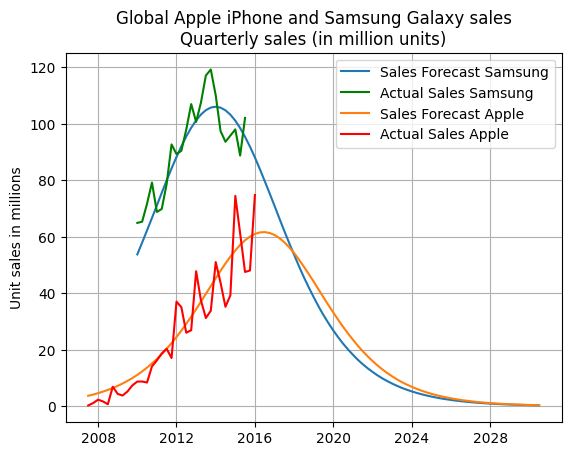

In [63]:
fig, ax = plt.subplots()
ax.plot(date_forecast_samsung, sales_forecast_samsung, label='Sales Forecast Samsung')
ax.plot(date_samsung, sales_samsung, color='green', label='Actual Sales Samsung')
ax.plot(date_forecast_apple, sales_forecast_apple, label='Sales Forecast Apple')
ax.plot(date_apple, sales_apple, color='red', label='Actual Sales Apple')
plt.ylabel('Unit sales in millions')
#plt.xlabel('time')
plt.title("Global Apple iPhone and Samsung Galaxy sales\nQuarterly sales (in million units)")
plt.legend()
ax.grid(True)
plt.show()

# References

https://srdas.github.io/MLBook/productForecastingBassModel.html#main-ideas

https://faculty.biu.ac.il/~fruchtg/829/lec/6.pdf

https://app.box.com/s/8uduwzfyezeoupqii76u7a6ro3somole?page=1

https://www.statsmodels.org/devel/example_formulas.html

https://www.datarobot.com/blog/ordinary-least-squares-in-python/

https://www.statista.com/statistics/263401/global-apple-iphone-sales-since-3rd-quarter-2007/

https://docs.python.org/3/howto/regex.html

https://stackoverflow.com/questions/53898482/clean-way-to-convert-quarterly-periods-to-datetime-in-pandas